# Chapter 5. Genetic algorithms
## 5.2. A generic gentic algorithm

__Defining abstract interface for chromosome__

In [1]:
from __future__ import annotations
from typing import TypeVar, Tuple, Type
from abc import ABC, abstractmethod

T = TypeVar("T", bound="Chromosome")

# Base class for all chromosomes
class Chromosome(ABC):
    @abstractmethod
    def fitness(self) -> float:
        """
        How close the chromosome is to the goal
        """
        pass
    
    @classmethod
    @abstractmethod
    def random_instance(cls: Type[T]) -> T:
        """
        Create class instance
        """
        pass
    
    @abstractmethod
    def crossover(self, other: T) -> Tuple[T, T]:
        """
        Interaction of two chromosomes
        """
        pass
    
    @abstractmethod
    def mutate(self) -> None:
        """
        Inject changes to the chromosome itself
        """
        pass

__Implementing genetic algorithm class__

In [28]:
from typing import Generic, List, Callable
from enum import Enum
from random import choices, random
from heapq import nlargest
from statistics import mean

C = TypeVar("C", bound="Chromosome")

class GeneticAlgorithm(Generic[C]):
    SelectionType = Enum("SelectionType", "ROULETTE TOURNAMENT")
    
    def __init__(self, initial_population: List[C], threshold: float,
                max_generations: int = 100, mutation_chance: float = 0.01,
                crossover_chance: float = 0.7, 
                selection_type: SelectionType = SelectionType.TOURNAMENT) -> None:
        self._population: List[C] = initial_population
        self._threshold: float = threshold
        self._max_generations: int = max_generations
        self._mutation_chance: float = mutation_chance
        self._crossover_chance: float = crossover_chance
        self._selection_type: GeneticAlgorithm.SelectionType = selection_type
        self._fitness_key: Callable = type(self._population[0]).fitness # Link to the method
            
    def _pick_roulette(self, wheel: List[float]) -> Tuple[C, C]:
        return tuple(choices(self._population, weights=wheel, k=2))
    
    def _pick_tournament(self, num_participants: int) -> Tuple[C, C]:
        participants: List[C] = choices(self._population, k=num_participants)
        return tuple(nlargest(2, participants, key=self._fitness_key))
    
    def _reproduce_and_replace(self) -> None:
        new_population: List[C] = []
        # Fill the whole generation
        while len(new_population) < len(self._population):
            # Selecting two parents
            if self._selection_type == GeneticAlgorithm.SelectionType.ROULETTE:
                parents: Tuple[C, C] = self._pick_roulette([x.fitness() for x in self._population])
            else:
                parents: Tuple[C, C] = self._pick_tournament(len(self._population) // 2)
            
            # Potential crossing of 2 parents
            if random() < self._crossover_chance:
                new_population.extend(parents[0].crossover(parents[1]))
            else:
                new_population.extend(parents)
        # If odd elements => remove it
        if len(new_population) > len(self._population):
            new_population.pop()
        self._population = new_population
    
    def _mutate(self) -> None:
        for individual in self._population:
            if random() < self._mutation_chance:
                individual.mutate()
    
    def run(self) -> C:
        best: C = max(self._population, key=self._fitness_key)
        best_list = []
        for generation in range(self._max_generations):
            best_list.append(best)
            # Early stop
            if best.fitness() >= self._threshold:
                return best, best_list
            print(f"Generation {generation} | Best {best.fitness()} | Avg {mean(map(self._fitness_key, self._population))}")
            self._reproduce_and_replace()
            self._mutate()
            highest: C = max(self._population, key=self._fitness_key)
            if highest.fitness() > best.fitness():
                best = highest
        return best, best_list

## 5.3. Primitive test: equation
__Find max x and y which maximize__: 6x - x^2 + 4y - y^2

In [29]:
import numpy as np
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

In [30]:
x_range = np.linspace(start=-20, stop=20, num=100)
y_range = np.linspace(start=-20, stop=20, num=100)
equation_range = x_range*6 - x_range**2 + y_range*4 - y_range**2

def equation(x, y):
    return x*6 - x**2 + y*4 - y**2

X,Y = meshgrid(x_range, y_range) # grid of point
Z = equation(X, Y)

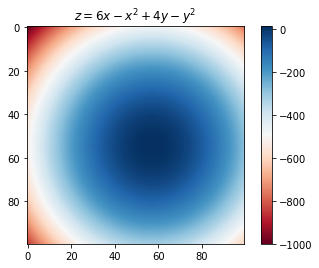

In [31]:
im = imshow(Z, cmap=cm.RdBu) # drawing the function
colorbar(im)
# latex fashion title
title('$z=6x - x^2 + 4y - y^2$')
show()

<ipython-input-32-1fd8de5ab68f>:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


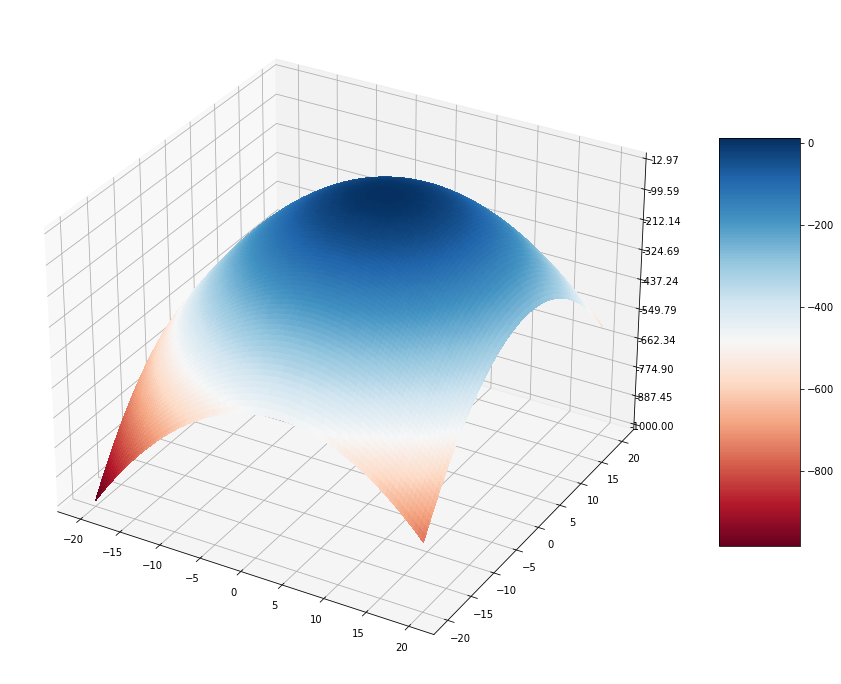

In [32]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

__Implement simple equation chromosome__

In [66]:
from random import randrange
from copy import deepcopy

class SimpleEquation(Chromosome):
    def __init__(self, x: int, y: int) -> None:
        self.x: int = x
        self.y: int = y
    
    def fitness(self) -> float:
        return self.x * 6 - self.x * self.x + self.y * 4 - self.y * self.y
    
    @classmethod
    def random_instance(cls) -> SimpleEquation:
        return SimpleEquation(randrange(100), randrange(100))
    
    def crossover(self, other: SimpleEquation) -> Tuple[SimpleEquation, SimpleEquation]:
        child1: SimpleEquation = deepcopy(self)
        child2: SimpleEquation = deepcopy(other)
        
        child1.y = other.y
        child2.y = self.y
        return child1, child2
    
    def mutate(self) -> None:
        if random() > 0.5:
            if random() > 0.5:
                self.x += 1
            else:
                self.x -= 1
        else:
            if random() > 0.5:
                self.y += 1
            else:
                self.y -= 1
    
    def __str__(self) -> str:
        return  f"X: {self.x} | Y: {self.y} | Fitness: {self.fitness()}"

__Solve the equation__ 

In [70]:
initial_population: List[SimpleEquation] = [SimpleEquation.random_instance() for _ in range(20)]
ga: GeneticAlgorithm[SimpleEquation] = GeneticAlgorithm(initial_population=initial_population, threshold=13.0,
                                                       max_generations=100, mutation_chance=0.1, crossover_chance=0.7)
result, best_list = ga.run()
print(result)

Generation 0 | Best -499 | Avg -7966.8
Generation 1 | Best -499 | Avg -3360.45
Generation 2 | Best -221 | Avg -789.6
Generation 3 | Best -221 | Avg -369.35
Generation 4 | Best -187 | Avg -221.4
Generation 5 | Best -187 | Avg -190.65
Generation 6 | Best -187 | Avg -188.45
Generation 7 | Best -160 | Avg -185.75
Generation 8 | Best -135 | Avg -173
Generation 9 | Best -135 | Avg -155.35
Generation 10 | Best -132 | Avg -144.4
Generation 11 | Best -132 | Avg -135.9
Generation 12 | Best -131 | Avg -132.65
Generation 13 | Best -108 | Avg -131.45
Generation 14 | Best -108 | Avg -127.8
Generation 15 | Best -108 | Avg -113.95
Generation 16 | Best -108 | Avg -108.05
Generation 17 | Best -87 | Avg -106.95
Generation 18 | Best -87 | Avg -103.9
Generation 19 | Best -87 | Avg -92.25
Generation 20 | Best -87 | Avg -88.1
Generation 21 | Best -87 | Avg -87.1
Generation 22 | Best -87 | Avg -88.05
Generation 23 | Best -87 | Avg -88.05
Generation 24 | Best -87 | Avg -87
Generation 25 | Best -87 | Avg -87.1


__Visualize the solution__

<ipython-input-71-af30d8cb179f>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


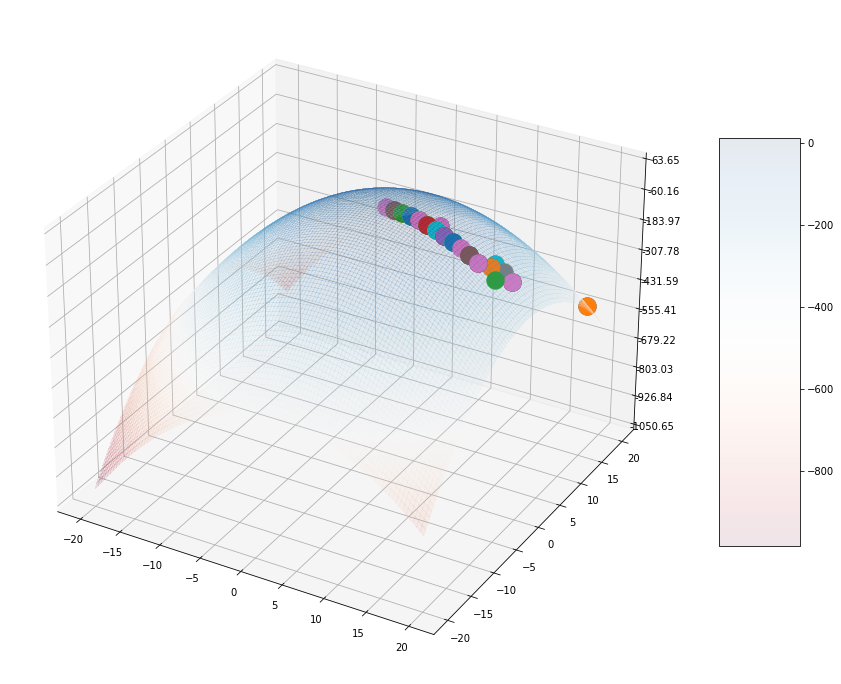

In [71]:
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False, alpha=0.1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

for idx, individual in enumerate(best_list):
    ax.scatter(individual.x, individual.y, individual.fitness(), s=300)
plt.show()

## 5.4. SEND + MORE = MONEY - improved version
For crypto-arithmetic problems we'll use list indices as numbers

In [74]:
from random import shuffle, sample

class SendMoreMoney2(Chromosome):
    def __init__(self, letters: List[str]) -> str:
        self.letters: List[str] = letters
    
    def fitness(self) -> float:
        s: int = self.letters.index('S')
        e: int = self.letters.index('E')
        n: int = self.letters.index('N')
        d: int = self.letters.index('D')
        m: int = self.letters.index('M')
        o: int = self.letters.index('O')
        r: int = self.letters.index('R')
        y: int = self.letters.index('Y')
        send: int = s*1000 + e*100 + n*10 + d
        more: int = m*1000 + o*100 + r*10 + e
        money: int = m*10000 + o*1000 + n*100 + e*10 + y
        difference: int = abs(money - (send + more))
        return 1 / (difference + 1)
    
    @classmethod
    def random_instance(cls) -> SendMoreMoney2:
        letters: List[str] = ["S", "E", "N", "D", "M", "O", "R", "Y", " ", " "]
        shuffle(letters)
        return SendMoreMoney2(letters)
    
    def crossover(self, other: SendMoreMoney2) -> Tuple[SendMoreMoney2, SendMoreMoney2]:
        child1: SendMoreMoney2 = deepcopy(self)
        child2: SendMoreMoney2 = deepcopy(other)
        idx1, idx2 = sample(range(len(self.letters)), k=2)
        l1, l2 = child1.letters[idx1], child2.letters[idx2]
        child1.letters[child1.letters.index(l2)], child1.letters[idx2] = child1.letters[idx2], l2
        child2.letters[child2.letters.index(l1)], child2.letters[idx1] = child2.letters[idx1], l1
        return child1, child2
    
    def mutate(self) -> None:
        idx1, idx2 = sample(range(len(self.letters)), k=2)
        self.letters[idx1], self.letters[idx2] = self.letters[idx2], self.letters[idx1]
        
    def __str__(self) -> str:
        s: int = self.letters.index('S')
        e: int = self.letters.index('E')
        n: int = self.letters.index('N')
        d: int = self.letters.index('D')
        m: int = self.letters.index('M')
        o: int = self.letters.index('O')
        r: int = self.letters.index('R')
        y: int = self.letters.index('Y')
        send: int = s*1000 + e*100 + n*10 + d
        more: int = m*1000 + o*100 + r*10 + e
        money: int = m*10000 + o*1000 + n*100 + e*10 + y
        difference: int = abs(money - (send + more))
        return f"{send} + {more} = {money} | Difference: {difference}"

__Applying algorithm__

In [83]:
initial_population: List[SendMoreMoney2] = [SendMoreMoney2.random_instance() for _ in range(1000)]
ga: GeneticAlgorithm[SendMoreMoney2] = GeneticAlgorithm(initial_population=initial_population, threshold=1.0,
                                                       max_generations=1000, mutation_chance=0.2, crossover_chance=0.7,
                                                       selection_type=GeneticAlgorithm.SelectionType.ROULETTE)
result, _ = ga.run()
print(result)

Generation 0 | Best 0.03125 | Avg 0.00012550047156801984
Generation 1 | Best 0.1 | Avg 0.0032079163103453066
Generation 2 | Best 0.25 | Avg 0.022062241515074348
Generation 3 | Best 0.5 | Avg 0.04126433817861795
Generation 4 | Best 0.5 | Avg 0.07277894406214092
Generation 5 | Best 0.5 | Avg 0.11821786923791762
Generation 6 | Best 0.5 | Avg 0.17170916345382328
Generation 7 | Best 0.5 | Avg 0.22848353447621683
Generation 8 | Best 0.5 | Avg 0.2918895849058022
Generation 9 | Best 0.5 | Avg 0.3225432299295597
Generation 10 | Best 0.5 | Avg 0.3422050549539044
Generation 11 | Best 0.5 | Avg 0.3634353199560517
Generation 12 | Best 0.5 | Avg 0.37899481717495914
Generation 13 | Best 0.5 | Avg 0.36613753736121185
Generation 14 | Best 0.5 | Avg 0.3835766895754913
Generation 15 | Best 0.5 | Avg 0.3852357666479268
Generation 16 | Best 0.5 | Avg 0.3931025549455313
Generation 17 | Best 0.5 | Avg 0.40047918901010043
Generation 18 | Best 0.5 | Avg 0.39295168030853467
Generation 19 | Best 0.5 | Avg 0.3829

## 5.5. Optimizing list compression
The order of elements in a list has an effect on the size of the compressed list.   
Our goal - find an order of elements that produces minimal size of the compressed list.

__Initial list__

In [85]:
from zlib import compress
from sys import getsizeof
from pickle import dumps

PEOPLE: List[str] = ["Michael", "Sarah", "Joshua", "Narine", "David", "Sajid",
                    "Melanie", "Daniel", "Wei", "Dean", "Brian", "Murat", "Lisa"]
print(f"Size of the compressed list: {getsizeof(compress(dumps(PEOPLE)))}")

Size of the compressed list: 142


__Create chromosome__

In [86]:
class ListCompression(Chromosome):
    def __init__(self, lst: List[Any]) -> None:
        self.lst: List[Any] = lst
    
    @property
    def bytes_compressed(self) -> int:
        return getsizeof(compress(dumps(self.lst)))
    
    def fitness(self) -> float:
        return 1/self.bytes_compressed
    
    @classmethod
    def random_instance(cls) -> ListCompression:
        mylst: List[str] = deepcopy(PEOPLE)
        shuffle(mylst)
        return ListCompression(mylst)
    
    def crossover(self, other: ListCompression) -> Tuple[ListCompression, ListCompression]:
        child1: ListCompression = deepcopy(self)
        child2: ListCompression = deepcopy(other)
        idx1, idx2 = sample(range(len(self.lst)), k=2)
        l1, l2 = child1.lst[idx1], child2.lst[idx2]
        child1.lst[child1.lst.index(l2)], child1.lst[idx2] = child1.lst[idx2], l2
        child2.lst[child2.lst.index(l1)], child2.lst[idx1] = child2.lst[idx1], l1
        return child1, child2
    
    def mutate(self) -> None:
        idx1, idx2 = sample(range(len(self.lst)), k=2)
        self.lst[idx1], self.lst[idx2] = self.lst[idx2], self.lst[idx1]
    
    def __str__(self) -> str:
        return f"Order: {self.lst} | Bytes: {self.bytes_compressed}"

__Solve the problem__

In [88]:
initial_population: List[ListCompression] = [ListCompression.random_instance() for _ in range(1000)]
ga: GeneticAlgorithm[ListCompression] = GeneticAlgorithm(initial_population=initial_population, threshold=1.0,
                                                        max_generations=15, mutation_chance=0.2, crossover_chance=0.7,
                                                        selection_type=GeneticAlgorithm.SelectionType.TOURNAMENT)
result, _ = ga.run()
print(result)

Generation 0 | Best 0.007194244604316547 | Avg 0.006985349985668404
Generation 1 | Best 0.007246376811594203 | Avg 0.007098180929370913
Generation 2 | Best 0.0072992700729927005 | Avg 0.007141886716962161
Generation 3 | Best 0.0072992700729927005 | Avg 0.007186550962694634
Generation 4 | Best 0.0072992700729927005 | Avg 0.007250779329574623
Generation 5 | Best 0.0072992700729927005 | Avg 0.007257606678464817
Generation 6 | Best 0.0072992700729927005 | Avg 0.007258928579432443
Generation 7 | Best 0.0072992700729927005 | Avg 0.0072583468990811036
Generation 8 | Best 0.0072992700729927005 | Avg 0.007258438039519459
Generation 9 | Best 0.0072992700729927005 | Avg 0.007259887742770291
Generation 10 | Best 0.0072992700729927005 | Avg 0.007261455016816768
Generation 11 | Best 0.0072992700729927005 | Avg 0.007261499462333567
Generation 12 | Best 0.0072992700729927005 | Avg 0.007262237536471403
Generation 13 | Best 0.0072992700729927005 | Avg 0.00726352739882101
Generation 14 | Best 0.007299270